## Đây là NOTEBOOK giúp visualize các giá trị đo lường để cân nhắc việc sử dụng Scheduler "Reduce LR On Plateau"

Các quá trình thực nghiệm được thể hiện trong các notebook sau:
1.   [Model MobileNetV3, không scheduler, nhận learning rate = 5e-5](https://colab.research.google.com/drive/119gHyxtZN8JAfFSC8ZN5s_Fn0WGiwjqR?usp=sharing)
2.   [Model MobileNetV3, có scheduler "Reduce Lr On Plateau", learning rate = 5e-5](https://colab.research.google.com/drive/1DzKmkps8jJ2h4he-N4VXYBaF10su5Q1j?usp=drive_link)
3.   [Model MobileNetV3, không scheduler, learning rate = 1e-8](https://colab.research.google.com/drive/1jIOqals9RLu_IX0TTu7T0_2Gh4Q0_j6-?usp=drive_link)

* Mã nguồn trong 3 NOTEBOOK gần như giống nhau
* Sự khác biệt của các NOTEBOOK chỉ nằm trong 2 yếu tố Scheduler & Learning rate như trình bày trên

Đường dẫn đến NOTEBOOK giải nghĩa và so sánh: https://drive.google.com/file/d/1F1VaHuGNwdoEFH77yuHi-rHKkNMW-88W/view?usp=drive_link

## Hình ảnh minh chứng cho việc learning rate đã giảm sau một khoảng thời gian (tính theo số lần train ***Epochs***) mà trong đó số lần vi phạm điều kiện của validation loss vượt quá độ kiên nhẫn của scheduler

Các Giải thích về điều kiện và độ kiên nhẫn của scheduler có thể được tham khảo ở đây:
[Pytorch: Reduce LR On Plateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html)


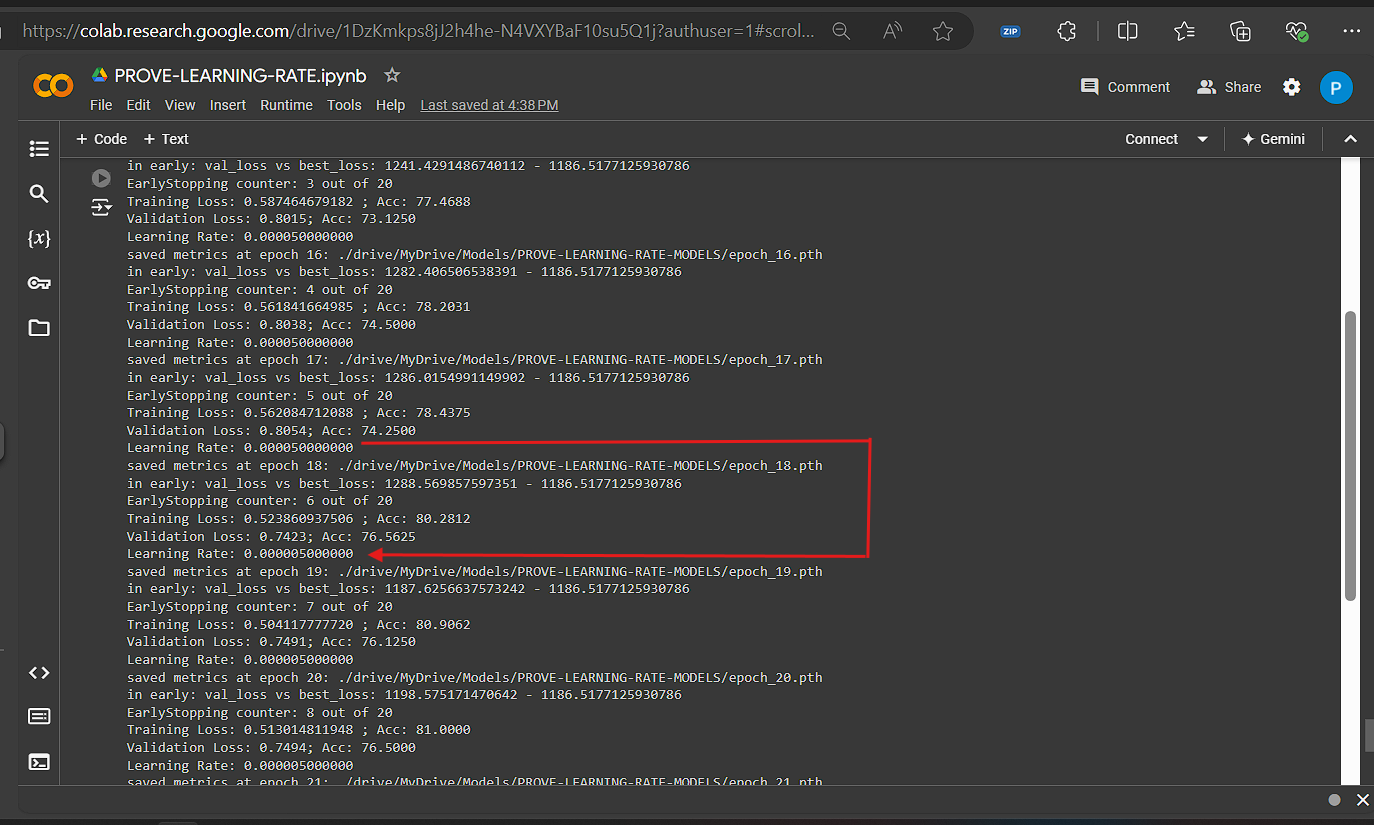




In [ ]:
import os
import random
import math
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import torch
import seaborn as sns
import json
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Plot ra những giá trị đo lường trong quá trình train trong 3 NOTEBOOK:


1.   [Model MobileNetV3, không scheduler, nhận learning rate = 5e-5](https://colab.research.google.com/drive/119gHyxtZN8JAfFSC8ZN5s_Fn0WGiwjqR?usp=sharing)
2.   [Model MobileNetV3, có scheduler "Reduce Lr On Plateau", learning rate = 5e-5](https://colab.research.google.com/drive/1DzKmkps8jJ2h4he-N4VXYBaF10su5Q1j?usp=drive_link)
3.   [Model MobileNetV3, không scheduler, learning rate = 1e-8](https://colab.research.google.com/drive/1jIOqals9RLu_IX0TTu7T0_2Gh4Q0_j6-?usp=drive_link)

* Đoạn code sau đọc các file .pth từ các
Diretory
* Load các thước đo (metrics) lên và hiển thị trên biểu đồ

In [ ]:
def extract_number(s):
				return int(s.split('.')[0].split('_')[1])

def load_and_plot_metrics(other_checkpoint_dirs = [],names=[]):
    metric_objs = []
    idx = 0
    for dirs in other_checkpoint_dirs:
        pth_files = os.listdir(dirs)
        if "best_model.pth" in pth_files:
          pth_files.remove('best_model.pth')
        # print(*pth_files)
        pth_files=sorted(pth_files,key=extract_number)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        lrs=[]
        train_losses_arr = []
        val_losses_arr = []
        epoch_arr = []
        for filename in pth_files:
          if filename.endswith('.pth') and (not filename.startswith('best')):
              checkpoint_path = os.path.join(dirs, filename)
              checkpoint = torch.load(checkpoint_path,map_location=device)
              epoch_arr.append(int(filename.split('_')[1].split('.')[0]))
              current_lr = int(checkpoint['lr'])
              lrs.append(current_lr)
              train_losses_arr.append(checkpoint['train_loss'])
              val_losses_arr.append(checkpoint['val_loss'])
        other_metric_dict = {
            "name": names[idx],
            "epochs":epoch_arr,
            "lrs":lrs,
            "val_losses":val_losses_arr,
            "train_losses":train_losses_arr
            }
        metric_objs.append(other_metric_dict)
        idx+=1

    plot_metrics(metric_objs)
    plot_metrics(metric_objs,
                 plot_name="train_losses",
                 plot_label="train loss",
                 title="Train loss over epochs")

def plot_metrics(metrics=[],
                 plot_name="val_losses",
                 plot_label="validation loss",
                 title="Validation Loss over epochs"):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 1, 1)
    # plt.plot(epochs, train_losses, label='Train Loss')
    # plt.plot(epochs, val_losses, label='Validation Loss')
    for metric in metrics:
      epochs = metric["epochs"]
      metric_name = metric["name"]
      # train_losses = metric["train_losses"]
      val_losses = metric[plot_name]
      # plt.plot(epochs,train_losses,label=f"{metric_name} train loss")
      plt.plot(epochs,val_losses,label=f"{metric_name} | {plot_label}")

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()




## Đây là cái file model sau khi đã train từ các notebook đã đính kèm ở trên

In [ ]:
! ls "drive/MyDrive/my_shared_shortcut/MODELS-logs"

DEMO-LEARNING-RATE-MODELS			   MOTO-IMAGES
DEMO-LEARNING-RATE-NO-SCHEDULER-LOW		   predictions-split-1.csv
DEMO-LEARNING-RATE-NO-SCHEDULER-MID		   predictions-split-2.csv
DEMO-LEARNING-RATE-train.csv			   predictions-split-3.csv
DEMO-LEARNING-RATE-UPDATE.csv			   predictions-split-4.csv
DEMO-LEARNING-RATE-val.csv			   predictions-split-5.csv
MotocycleDataset-DEMO-cluster-duplicates-1000.csv  TP-models.zip


### Đoạn code giúp hiển thị ***Training loss over epoch*** và ***Validation loss over epochs*** từ quá trình train trong 3 notebook trên

1. Nhận xét cho biểu đồ Validation Loss over epoch:

&nbsp;&nbsp;&nbsp; 1.1 Đối với việc train với Learning rate = 5e-5, không scheduler
*  validation loss dao động rất nhiều, không ổn định qua các lần train (epoch).
* Do đó, càng về các epoch sau, vô cùng khó có thể điều tiết weight sao cho validation loss giảm dần theo thời gian.
<br>

&nbsp;&nbsp;&nbsp; 1.2 Đối với việc train với Learning rate = 5e-5, không scheduler
* validation dao động nhiều với những epoch đầu tiên.
* Tuy nhiên, khi vượt qua **mức độ kiên nhẫn** của scheduler. Scheduler đã điều tiết learning rate xuống, để gradient giảm chậm hơn.
* Do đó, đường đi của validation loss sẽ giảm dù chậm nhưng chắc chắn sẽ giảm dần theo các lần train sau

&nbsp;&nbsp;&nbsp; 1.3 Đối với việc train với Learning rate = 1e-8, không scheduler
<br>
* Chọn learning rate quá nhỏ, validation loss gần như không đổi qua các epoch
* Do đó có thể sau khoảng thời gian train rất lâu, việc train vẫn sẽ không đạt validation loss như mong muốn
<br>
Chú thích:
<br>
Câu hỏi: "Rất lâu là bao lâu?"
<br>
Trả lời: "Rất lâu, ở đây là rất nhiều epoch. Vì epoch là số lần train qua cả dataset. Do đố, nếu 1 epoch train trong 25 phút, ta train với 150 epoch: thời gian là 25 x 150 = 3.750 phút"
<br>

2. Nhận xét cho biểu đồ Validation Loss over epoch:

&nbsp;&nbsp;&nbsp; 2.1 Đối với việc train Learning rate với Learning rate = 5e-5, không scheduler
*  Training loss giảm dần theo thời gian, đối nghịch với độ dao động của validation loss
*  Quá trình train đang cố gắng fit data trên training set, thay vì cân bằng việc nhận diện feature của các đối tượng ảnh trên cả validation set
<br>
=> dẫn đến việc model sẽ cho ra Accuracy rất tệ trên test set sau này
<br>

&nbsp;&nbsp;&nbsp; 2.2 Đối với việc train Learning rate với Learning rate = 5e-5, không scheduler
* Training loss giảm dần theo thời gian. Song song với sự giảm dần ổn định của validation losss
* Do đó, đường đi của trainging và validation loss sẽ giảm dù chậm nhưng chắc chắn sẽ giảm dần theo các lần train sau
=> dẫn đến việc model sẽ cho ra Accuracy tốt hơn trên test set sau này

&nbsp;&nbsp;&nbsp; 2.3 Đối với việc train Learning rate với Learning rate = 1e-8, không scheduler
<br>
* Chọn learning rate quá nhỏ, training loss gần như không đổi qua các epoch

=> Kết luận:
* Việc sử dụng scheduler để update learning rate là rất tốt, nó giúp model cân bằng giữa việc fit bộ weights và biases trên cả trainning set & validation set
* Tăng thêm số lần train sẽ nhận thấy sự giảm ổn định của validation loss khi dùng scheduler




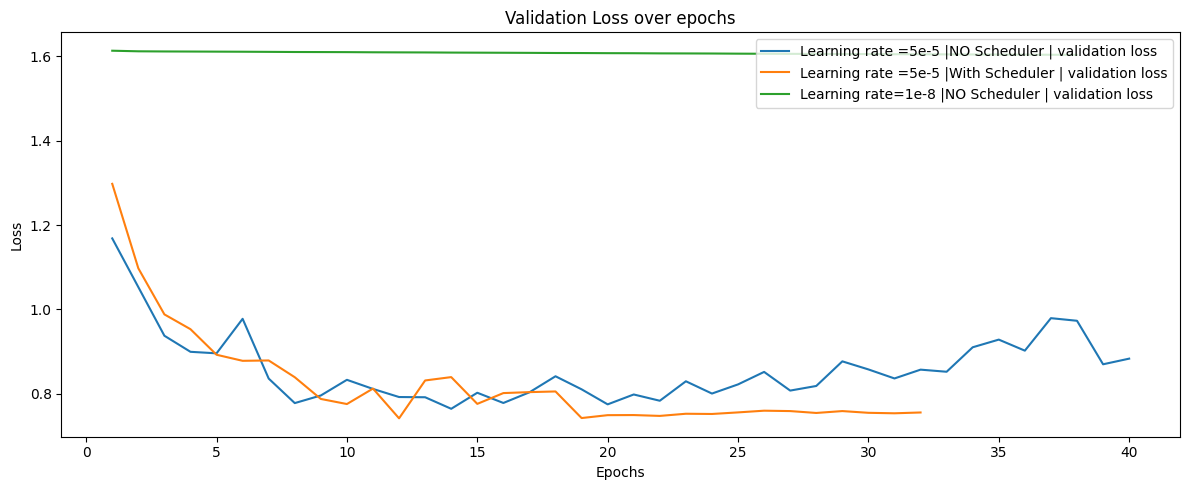

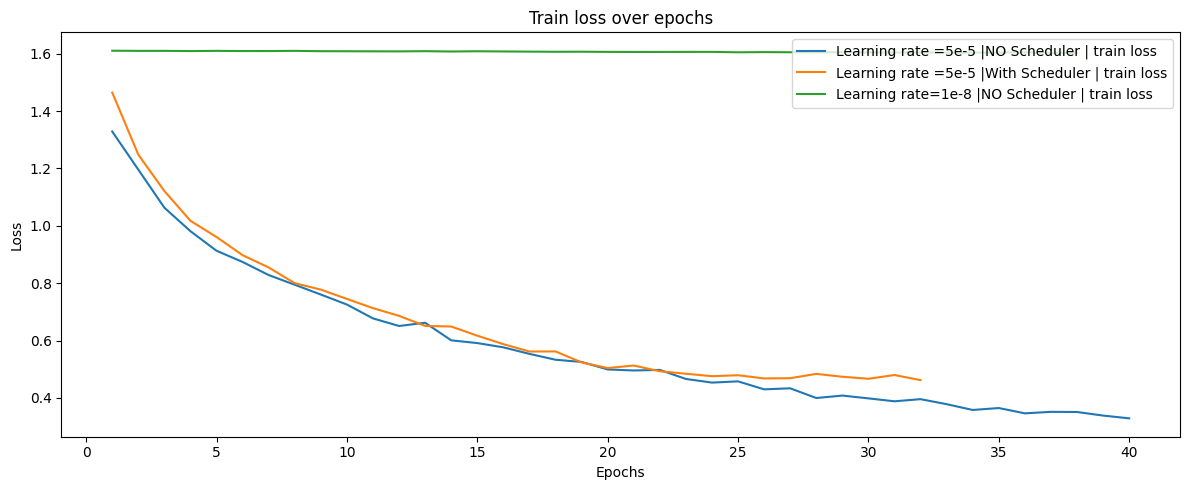

In [ ]:
base_dir = "drive/MyDrive/my_shared_shortcut/MODELS-logs"
model_dirs = [
    f"{base_dir}/DEMO-LEARNING-RATE-NO-SCHEDULER-MID",
    f"{base_dir}/DEMO-LEARNING-RATE-MODELS",
    f"{base_dir}/DEMO-LEARNING-RATE-NO-SCHEDULER-LOW",
    ]
item_names = [
    "Learning rate =5e-5 |NO Scheduler",
    "Learning rate =5e-5 |With Scheduler",
    "Learning rate=1e-8 |NO Scheduler",
    ]
load_and_plot_metrics(model_dirs,item_names)